## import

In [1]:
import numpy as np
import os, random
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, Dropout
from tensorflow.keras.layers import Convolution1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Lambda
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

C:\Users\HW-steve\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\HW-steve\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\HW-steve\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\HW-steve\AppData\Roaming\Python\Py

## random seed

In [2]:
ramdom_seed = 5198
tf.random.set_random_seed(ramdom_seed)
np.random.seed(ramdom_seed)
random.seed(ramdom_seed)
os.environ['PYTHONHASHSEED'] = str(ramdom_seed)

## GPU growth

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

## Preprocessing function

In [4]:
def mat_mul(A, B):
    return tf.matmul(A, B)

def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    return (data, label)

def rotate_point_cloud(batch_data):
    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        rotation_angle = np.random.uniform() * 2 * np.pi
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, 0, sinval],
                                    [0, 1, 0],
                                    [-sinval, 0, cosval]])
        shape_pc = batch_data[k, ...]
        rotated_data[k, ...] = np.dot(shape_pc.reshape((-1, 3)), rotation_matrix)
    return rotated_data

def jitter_point_cloud(batch_data, sigma=0.001, clip=0.005):
    B, N, C = batch_data.shape
    assert(clip > 0)
    jittered_data = np.clip(sigma * np.random.randn(B, N, C), -1 * clip, clip)
    jittered_data += batch_data
    return jittered_data

In [5]:
# number of points in each sample
num_points = 10000

# number of categories
k = 3

# define optimizer
adam = optimizers.Adam(lr=0.001, decay=0.7)

# ------------------------------------ Pointnet Architecture
# input_Transformation_net
input_points = Input(shape=(num_points, 3))
x = Convolution1D(64, 1, activation='relu', input_shape=(num_points, 3))(input_points)
x = Convolution1D(128, 1, activation='relu')(x)
x = Convolution1D(1024, 1, activation='relu')(x)
x = MaxPooling1D(pool_size=num_points)(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(9, weights=[np.zeros([256, 9]), np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32)])(x)
input_T = Reshape((3, 3))(x)

# forward net
g = Lambda(mat_mul, arguments={'B': input_T})(input_points)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)

# feature transform net
f = Convolution1D(64, 1, activation='relu')(g)
f = Convolution1D(128, 1, activation='relu')(f)
f = Convolution1D(1024, 1, activation='relu')(f)
f = MaxPooling1D(pool_size=num_points)(f)
f = Dense(512, activation='relu')(f)
f = Dense(256, activation='relu')(f)
f = Dense(64 * 64, weights=[np.zeros([256, 64 * 64]), np.eye(64).flatten().astype(np.float32)])(f)
feature_T = Reshape((64, 64))(f)

# forward net
g = Lambda(mat_mul, arguments={'B': feature_T})(g)
g = Convolution1D(64, 1, activation='relu')(g)
g = Convolution1D(128, 1, activation='relu')(g)
g = Convolution1D(1024, 1, activation='relu')(g)

# global_feature
global_feature = MaxPooling1D(pool_size=num_points)(g)

# point_net_cls
c = Dense(512, activation='relu')(global_feature)
# c = Dropout(rate=0.2)(c)
c = Dense(256, activation='relu')(c)
# c = Dropout(rate=0.2)(c)
c = Dense(k, activation='sigmoid')(c)
prediction = Flatten()(c)
# --------------------------------------------------end of pointnet

# print the model summary
model = Model(inputs=input_points, outputs=prediction)
model.compile(optimizer='Adam', loss='MSE', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10000, 3)]        0         
_________________________________________________________________
lambda (Lambda)              (None, 10000, 3)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10000, 64)         256       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10000, 64)         4160      
_________________________________________________________________
lambda_1 (Lambda)            (None, 10000, 64)         0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 10000, 64)         4160      
_________

In [6]:
data_path = 'D:/DATA/data_2020-05-21_knu_deid/data_ply_np.npy'

In [7]:
train_np = np.load(data_path)
# train_jitter = jitter_point_cloud(train_np, sigma = 0.1, clip = 1)

label_path = 'D:/DATA/data_2020-05-21_knu_deid/angle_class_labels.csv'
df = pd.read_csv(label_path, delimiter=',')
anger_label = df['Angle Class Model'].tolist() 
anger_label_np = np.array(anger_label)

In [8]:
train_np.shape

(129, 10000, 3)

In [9]:
def data_generator(train_np, anger_label_np, batch_size, aug = True):
    idx = 0
    idx_list = list(range(train_np.shape[0])) # random shuffle index generation
    anger_label_cate = to_categorical(anger_label_np -1)
    
    while 1:        
        if idx > len(idx_list) - batch_size:
            tmp_list = idx_list[idx:]
            idx = 0
        else:
            tmp_list = idx_list[idx:idx+batch_size] # end of list batch 
            idx = idx + batch_size
            
        batch_points = train_np[tmp_list, ...]
        batch_labels = anger_label_cate[tmp_list, ...]

        if aug == True:
            train_points_jitter = jitter_point_cloud(batch_points, sigma = 0.1, clip = 1)
        else:
            train_points_jitter = batch_points
                
        yield train_points_jitter, batch_labels

In [10]:
batch_size = 32

In [11]:
train_gen = data_generator(train_np, anger_label_np, batch_size, aug = False)

In [12]:
filepath = "03_test/model-{epoch:04d}-{loss:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, save_weights_only=True)

In [13]:
model_hist = model.fit_generator(train_gen, steps_per_epoch = int(129/batch_size), epochs = 1000, callbacks = [checkpoint])

Epoch 1/1000
4/4 [==============================] - 4s 999ms/step - loss: 0.4969 - acc: 0.0859
Epoch 2/1000
4/4 [==============================] - 1s 236ms/step - loss: 0.3772 - acc: 0.4433
Epoch 3/1000
4/4 [==============================] - 1s 204ms/step - loss: 0.3272 - acc: 0.3299
Epoch 4/1000
4/4 [==============================] - 1s 203ms/step - loss: 0.2835 - acc: 0.4124
Epoch 5/1000
4/4 [==============================] - 1s 206ms/step - loss: 0.2011 - acc: 0.4124
Epoch 6/1000
4/4 [==============================] - 1s 254ms/step - loss: 0.2647 - acc: 0.3047
Epoch 7/1000
4/4 [==============================] - 1s 203ms/step - loss: 0.2524 - acc: 0.0825
Epoch 8/1000
4/4 [==============================] - 1s 204ms/step - loss: 0.2139 - acc: 0.3402
Epoch 9/1000
4/4 [==============================] - 1s 203ms/step - loss: 0.2059 - acc: 0.4124
Epoch 10/1000
4/4 [==============================] - 1s 206ms/step - loss: 0.2088 - acc: 0.4124
Epoch 11/1000
4/4 [==============================

In [14]:
model_hist.history.keys()

dict_keys(['loss', 'acc'])

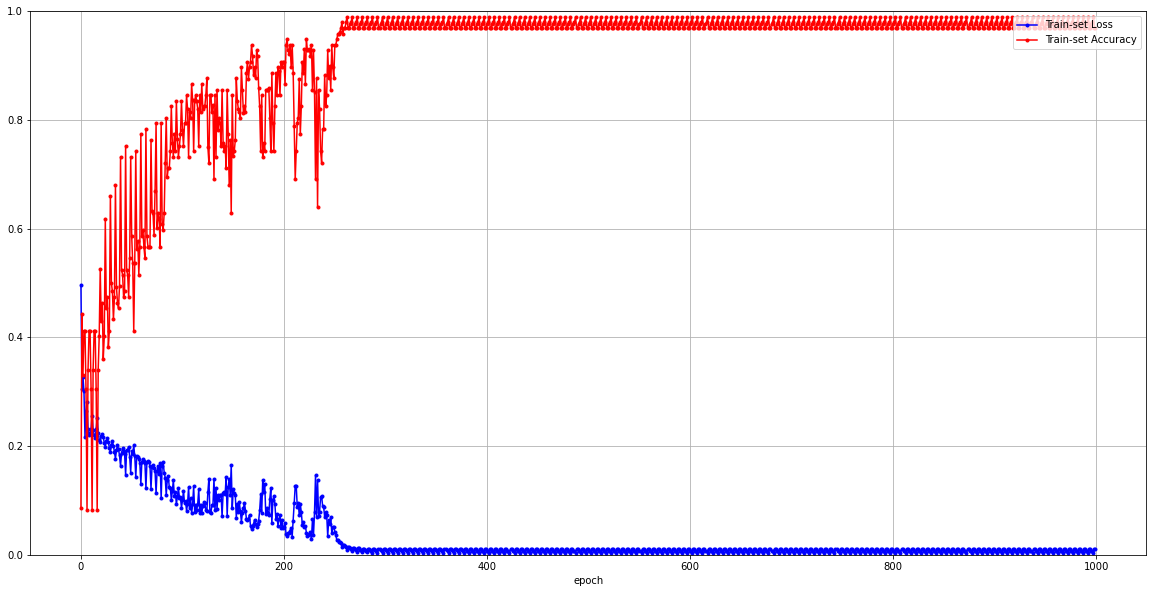

In [15]:
y_loss = model_hist.history['loss']
y_acc = model_hist.history['acc']

x_len = np.arange(len(y_loss))

plt.figure(figsize = (20, 10))
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")
plt.plot(x_len, y_acc, marker='.', c='red', label="Train-set Accuracy")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylim((0, 1))
plt.show()